# Mapping likelihood parameters to simulation parameters

Our likelihood is parameterize with a set of parameters $\theta$ describing the linear power spectrum at $z_\star=3$.

To evaluate the likelihood, at each redshift we use the parameters $\theta$ and the nuisance parameters $\phi$ to get the corresponding value of the emulator parameters $\mu$. The emulator looks for the snapshots in our arxiv with similar $\mu$ values, and returns the emulated 1D power spectrum. 

While setting up the emulator, and when preparing a "refinement step", we need to decide what simulations to run. These simulations are not specified by either likelihood parameters ($\theta$,$\phi$), or by emulator parameters $\mu$. Instead, the simulations are specified by a different set of parameters $\eta$, including for instance the redshift of reionization or the traditional cosmological parameters.

In other notebooks we have discussed how to go from cosmological parameters to likelihood parameters, or from likelihood parameters to emulator parameters. Here we will describe the inverse mapping, from linear power parameters $\theta$ to simulation parameters $\mu$, in particular the cosmological parameters. In a different notebook we will discuss how to map the nuisance parameters in the likelihood, $\phi$, to the astrophysical parameters in the simulation.

### Likelihood parameters: linear power $\Theta$

We will use a maximum of five parameters to describe the linear power spectrum across the redshift range of interest.

$$ \Theta = \{ \Delta_p^2, n_p, \alpha_p, f_\star, g_\star \} = \{ \Theta_p, f_\star, g_\star \} $$

Three of them will describe the linear power at $z_\star$, in velocity units (km/s). We will use a Taylor expansion of the logarithm of the linear power around $k_p = 0.009$ s/km. 

$$ \Delta_p^2 = \frac{k_p^3}{2 \pi^2} P_L(z_\star,k_p) $$

$$ n_p = \frac{\partial \log P_L(z_\star, k)}{\partial \log(k) } \Bigr\rvert_{k_p} $$

$$ \alpha_p = \frac{\partial^2 \log P_L(z_\star, k)}{\partial \log^2(k) } \Bigr\rvert_{k_p} $$

The other two will describe the redshift evolution of the linear growht $D(z)$ and the Hubble expansion $H(z)$, with respect $z_\star=3$, normalized by the expected evolution in an Einstein-de Sitter universe. 

$$ f_\star = f(z_\star) = \frac{\partial \log D(z)}{\partial \log a(z)} \Bigr\rvert_{z_\star} $$

$$ g_\star = g(z_\star) = \frac{\partial \log H(z)}{\partial \log (1+z)^{3/2}} \Bigr\rvert_{z_\star} $$


### Likelihood parameters: nuisance $\Phi$
- Mean flux: We will have a handful of parameters to describe the mean transmitted flux fraction (or mean flux) across the relevant redshift range. We will refer to these parameters as the $\Phi^\tau$ parameters, since they will parameters the effective optical depth $\tau_{\rm eff} = - \log \bar F$. There are several parameterizations possible (take a look at mean_flux.ipynb), but for now we choose a polynomial in $x_z = \log ((1+z)/(1+z_\star))$, of order $N_\tau-1$.

$$ \ln \tau_{\rm eff}(x_z) = \sum_{n=0}^{N_\tau-1} \phi^\tau_n \, x_z^n  \qquad \qquad x_z = \log \frac{1+z}{1+z_\star} $$

A popular choice in the literature is to assume a power law, i.e., use $N_\tau=2$. We probably want to go beyond that.

- Temperature / density relation (TDR): it is common to describe the termal state of the IGM with two parameters, describing a power law relation between temperature and density, valid around the mean density:
$$ T(\rho)= \left(\frac{\rho}{\rho_0}\right)^{\gamma-1} T_0$$
Even though this is a over-simplified description, we hope that this parameterization should be enough to marginalize over the uncertainties on the thermal state at a given point. 
Similarly to the mean flux case, we will describe the redshift evolution of $T_0$ and $\gamma$ with polynomials in $x_z$:
$$ \ln T_0(x_z) = \sum_{n=0}^{N_T-1} \phi^T_n \, x_z^n  \qquad \qquad \ln \gamma(x_z) = \sum_{n=0}^{N_\gamma-1} \phi^\gamma_n \, x_z^n $$

Here as well a popular choice is to assume a power law ($N_T=N_\gamma=2$). We might also go beyond that.

- Pressure smoothing: the last nuisance relevant for the emulator is the effect of pressure in the small scale distribution of the gas. 
This is different than the effect of "instantaneous" temperature, since the amount of pressure smoothing at a given time depends on the past thermal history. 
The effect of pressure is often parameterized using a "filtering length" $\lambda_F$, in velocity units, or its Fourier equivalent $k_F = 2 \pi / \lambda_F$. There are different ways of defining this length, and of measuring it from simulations, but we will not worry about it here. We assume that whatever we do is enough to marginalize over this uncertainty.
Similarly to the mean flux case, we will describe the redshift evolution of filtering length with a polynomial in $x_z$:
$$ \ln \lambda_F(x_z) = \sum_{n=0}^{N_T-1} \phi^\lambda_n \, x_z^n $$

Note that this is often not the approach used in the literature, where it is more common to see the effect of pressure smoothing either ignored or parameterized with the redshift of reionization. 
The relation between the two of them is discussed in another notebook.
For now we assume that we will use a polynomial for $\lambda_F$, with $N_\lambda=2$ or $3$.

### Emulator parameters $M$

The relation between the likelihood parameters ($\Theta$,$\Phi$) and the emulator parameters $M$ is discussed in the notebook full_likelihood. The emulator will have training set containing a large number of simulated spectra, identified by a list of parameters $M$:
$$ M = \{ M_P, f, \lambda_F, \bar F, \sigma_T, \gamma \} $$
where $M_P$ is a set of (3) parameters describing the linear power in the snapshot, in units of Mpc, $f$ allows us to translate that to the velocity power spectrum, and $\sigma_T$ is the thermal broadening corresponding to $T_0$:

$$ \sigma_T (T_0) = 9.1  \sqrt{ \frac{T_0}{10000K} } \, \mathrm{km/s} $$

Note that in the emulator $\sigma_T$ will be converted to comoving units in the same way that we have converted the linear power from velocity to comoving units.

### Simulation parameters $H$

From each simulation we run, we will output a number of snapshots, of order 10. 

Moreover, for each snapshot we extract different sets of simulated Lyman-$\alpha$ skewers (normalized quasar spectra), after applying different rescalings of the temperatures in the snapshot. 
These skewers are written to disk.

Finally, from each set of skewers we measure different 1D power spectra, after rescaling the mean optical depth in the spectra. 
This optical depth rescaling is trivial, and it is done on the fly. 
Each of these measured power spectra is fed to the emulator. 


Let's discuss the parameterization of each of the simulation packages:

- As we discuss above, the emulator labels the measured power with the set of parameters $ M = \{ M_P, f, \lambda_F, \bar F, \sigma_T, \gamma \} $.

- Each set of simulated skewers, written to disk, is described by a subset of these $ \{ M_P, f, \lambda_F, \sigma_T, \gamma \} $, since we will have different values of $\bar F$ from the skewers.

- Each snapshot is described by an even smaller subset of parameters, $ \{ M_P, f, \lambda_F \} $, since we will reprocess the snapshot for different temperature-density relations.

If we assumed that we can do as much rescaling of mean flux and temperature as we wanted, then this last set of parameters $ \{ M_P, f, \lambda_F \} $ would be the only relevant ones. If we can not rescale as much as we would like to (because the rescaling breaks down at some point?), then we would need to label the snapshots with a "central temperature" and "central mean flux", around which we would perturb. 

Now, since we are describing the linear power in comoving units, the shape of the linear power will be the same in all snapshots. The only parameters that will vary are the amplitude of the linear power, the logarithmic growth rate $f$ and the filtering length $\lambda_F$. So each simulation will be described by two shape parameters, and $N_z \times \{ A_p, f, \lambda_F \}$, where $N_z$ is the number of snapshots. 

$$ H = \{ n_p, \alpha_p, N_z \times \{ A_p, f, \lambda_F \} \} $$


The question is: how do we decide what simulation to run, i.e., what configuration files to use, if we are handed a set of parameters $H$? We will not aim at having a perfect match between the two, we just want to get on the right ball park.

From the point of view of cosmological parameters:
 - We start by defining a fiducial cosmology, somewhere around Planck, but WITHOUT NEUTRINOS. This is important, since our simulations will not have neutrinos. All quantities with $^0$ will refer to that fiducial cosmology. 
 - In flat $\Lambda$CDM models, we can translate the requirement of a given $f_\star$ into a requirement of a given $\Omega_\star = \Omega_{cb}(z_\star)$, using $f_\star = \Omega_\star^{0.55}$.
 - We can then translate the requirement on $\Omega_\star$ to a requirement on $\Omega_{cb} = \Omega_{cb}(z=0)$, using $\Omega_\star = \Omega_{cb} (1+z_\star)^3 / ( \Omega_{cb} (1+z_\star)^3 + 1 - \Omega_{cb} ) $. 
 - We will keep fixed the values of $\Omega_c h^2$ and $\Omega_b h^2$, so the requirement on $\Omega_{cb}$ will translate into a requirement on $h$, using $h^2 = (\Omega_b h^2 + \Omega_c h^2)/\Omega_{cb} $.
 - We will also measure the shape of the linear power at $z_\star$ around $k_p$, and modify the slope and running of the primordial power to match the required shape.
 - So the cosmology in the simulation will be specified by $\{ h, A_p, n_p, \alpha_p \}$, where $A_p$ will be computed at $z_\star$.

From the point of view of the pressure smoothing:
 - We will look at the value of the filtering length at a pre-HeII and at a post-HeII redshift, say z=2 and z=4. 
 - We will use the Oñorbe models to translate the required values for $\lambda_F$ pre- and post-HeII reionization to a required thermal history. It will probably be enough to specify a scaling of the heating rates before ($\mu_H$) and after ($\mu_{He}$) He_II reionizaion. 

### Relation between ($f_\star$,$g_\star$) and $\Omega_m$

$$ \Omega_\star = \frac{ \Omega_{cb} (1+z_\star)^3}{E(z_\star)} = \frac{ \Omega_{cb} (1+z_\star)^3}{\Omega_{cb} (1+z_\star)^3 + 1 - \Omega_{cb}} $$

$$ \Omega_{cb}  = \frac{\Omega_\star}{ (1+z_\star)^3 + \Omega_\star - \Omega_\star (1+z_\star)^3 } $$

In [1]:
%matplotlib inline
import numpy as np
import os
import copy
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb
from camb import model, initialpower
import fit_pk
import read_genic

In [3]:
# setup fiducial cosmology
cosmo_fid = fit_pk.get_cosmology(mnu=0.0)
fit_pk.print_info(cosmo_fid)
# fit power around this
z_star=3.0
kp_Mpc=0.7
# get linear power parameters, in comoving units
linP_params_fid=fit_pk.parameterize_cosmology_Mpc(cosmo_fid,z_star=z_star,kp_Mpc=kp_Mpc)
print('fiducial cosmology parameters',linP_params_fid)

H0 = 67.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
fiducial cosmology parameters {'f_star': 0.98136698840516934, 'g_star': 0.9677508579459803, 'linP_Mpc': poly1d([-0.10748482, -2.30758676,  3.02860938])}


In [4]:
# define target cosmology
target_f_star=0.98
target_lnA_p = 2.5
target_n_p = -2.25
target_alpha_p = - 0.12

In [5]:
def Om_star_from_f_star(f_star):
    return f_star**(1/0.55)

In [6]:
def Om_star_from_Om(Om,z_star=3):
    z3=(1+z_star)**3
    Om_star=Om*z3/(Om*z3+1-Om)
    return Om_star

In [7]:
def Om_from_Om_star(Om_star,z_star=3):
    z3=(1+z_star)**3
    Om=Om_star/(z3+Om_star-Om_star*z3)
    return Om

In [8]:
def Omh2_from_cosmo(cosmo):
    Obh2=cosmo_fid.ombh2 
    Och2=cosmo_fid.omch2
    Omh2=Obh2+Och2
    return Omh2

In [9]:
# translate these to requirements in cosmological parameters
target_Om_star=Om_star_from_f_star(target_f_star)
target_Om=Om_from_Om_star(target_Om_star,z_star)
print('target O_m =',target_Om)

target O_m = 0.2945881074873065


In [10]:
h=np.linspace(0.60,0.80,100)
Omh2=Omh2_from_cosmo(cosmo_fid)
Om=Omh2/h**2
Om_star=Om_star_from_Om(Om,z_star)

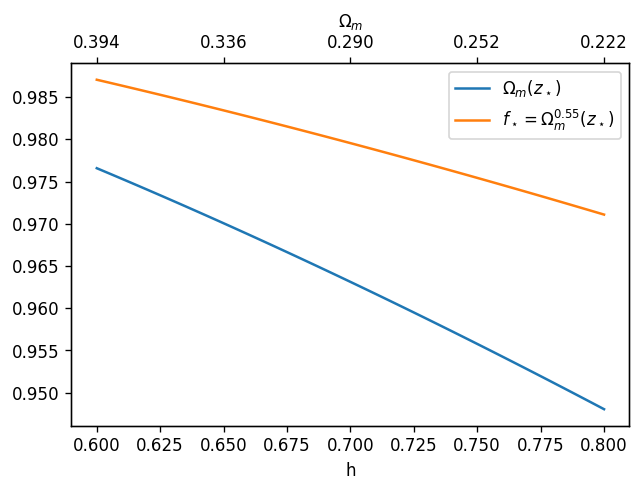

In [11]:
# fancy plot exploring values of f_star and g_star when you vary (Omegam_m,h)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(h,Om_star,label=r'$\Omega_m(z_\star)$')
ax1.plot(h,Om_star**(0.55),label=r'$f_\star = \Omega^{0.55}_m(z_\star)$')
ax1.legend()
ax1.set_xlabel('h')

# add 5 ticks
tick_h = np.linspace(min(h),max(h),5)
def Om_from_h(Omh2,h):
    Om = Omh2/h**2
    return ["%.3f" % z for z in Om]
Om_labels=Om_from_h(Omh2,tick_h)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(tick_h)
ax2.set_xticklabels(Om_labels)
ax2.set_xlabel(r'$\Omega_m$')
plt.show()

In [5]:
# specify target cosmology, and parameterize it
cosmo_target=fit_pk.get_cosmology(mnu=0.0,H0=75.0)
fit_pk.print_info(cosmo_target)
theta_target=fit_pk.parameterize_cosmology_Mpc(cosmo_target,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_target)

H0 = 75.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.97495182314028261, 'g_star': 0.9562014848059245, 'linP_Mpc': poly1d([-0.10752873, -2.30755578,  3.02420959])}


In [38]:
# use parameters to get a cosmology with similar parameters
#mimic_cosmo(theta_target['linP_Mpc'],kp_Mpc,theta_target['f_star'],z_star)
cosmo_mimic=H0_from_f_star(theta_target['f_star'],z_star)
fit_pk.print_info(cosmo_mimic)
theta_mimic=fit_pk.parameterize_cosmology_Mpc(cosmo_mimic,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_mimic)

H0 = 75.56291066444942 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.97447962015461742, 'g_star': 0.9553508628875105, 'linP_Mpc': poly1d([-0.10751988, -2.3075532 ,  3.02388087])}


In [39]:
# specify target cosmology, and parameterize it
cosmo_target=fit_pk.get_cosmology(mnu=0.0,H0=65.0)
fit_pk.print_info(cosmo_target)
theta_target=fit_pk.parameterize_cosmology_Mpc(cosmo_target,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_target)
# use parameters to get a cosmology with similar parameters
#mimic_cosmo(theta_target['linP_Mpc'],kp_Mpc,theta_target['f_star'],z_star)
cosmo_mimic=H0_from_f_star(theta_target['f_star'],z_star)
fit_pk.print_info(cosmo_mimic)
theta_mimic=fit_pk.parameterize_cosmology_Mpc(cosmo_mimic,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_mimic)

H0 = 65.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.9828721852971305, 'g_star': 0.970474934430218, 'linP_Mpc': poly1d([-0.10747232, -2.30760956,  3.02965133])}
H0 = 65.72642171861833 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.98232360287645815, 'g_star': 0.969493302088114, 'linP_Mpc': poly1d([-0.10746341, -2.30763938,  3.02928554])}


In [21]:
def H0_from_f_star(cosmo_fid,f_star,z_star):
    """Modify fiducial cosmology, to have the right f_star"""
    # will not modify physical densities
    Obh2=cosmo_fid.ombh2 
    Och2=cosmo_fid.omch2
    Omh2=Obh2+Och2
    # figure out desired Om(z=z_star) from desired f(z_star)
    Om_star=Om_star_from_f_star(f_star)
    # from Om(z_star), compute Om(z=0) in flat LCDM
    Om=Om_from_Om_star(Om_star_,z_star)
    # given Omega_m, figure out Hubble parameter
    h=np.sqrt(Omh2/Om)
    return 100*h

In [4]:
def mimic_cosmo(target_linP_Mpc,kp_Mpc,target_f_star,z_star):
    """Modify fiducial cosmology, to have the right linear power at z_star (in comoving units) and f_star"""
    cosmo_fid=fit_pk.get_cosmology(mnu=0.0)
    # will not modify physical densities
    ombh2=cosmo_fid.ombh2 
    omch2=cosmo_fid.omch2
    ommh2=ombh2+omch2
    # figure out desired Om(z=z_star) from desired f(z_star)
    omm_star=target_f_star**(1/0.55)
    # from Om(z_star), compute Om(z=0) in flat LCDM
    omm=1/(1+(1+z_star)**3*(1/omm_star-1))
    # given Omega_m, figure out Hubble parameter
    h=np.sqrt(ommh2/omm)
    cosmo=fit_pk.get_cosmology(mnu=0.0,H0=100.0*h)
    # get linear power for this cosmology, at z_star
    k_Mpc, _, linP_Mpc=fit_pk.get_linP_Mpc(pars,snap_zs)
    # 
    fit_pk.get_linP_Mpc(pars,snap_zs)
    return cosmo